### Only plot the inset plot

C:\Users\Sophie\AppData\Local\Temp\ipykernel_25652\4022456211.py:208: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(start_longitude, start_latitude, 'ro',color='black', markersize=12,label=f'Location & Prior heading',zorder=9) #(86.5W, 21N)


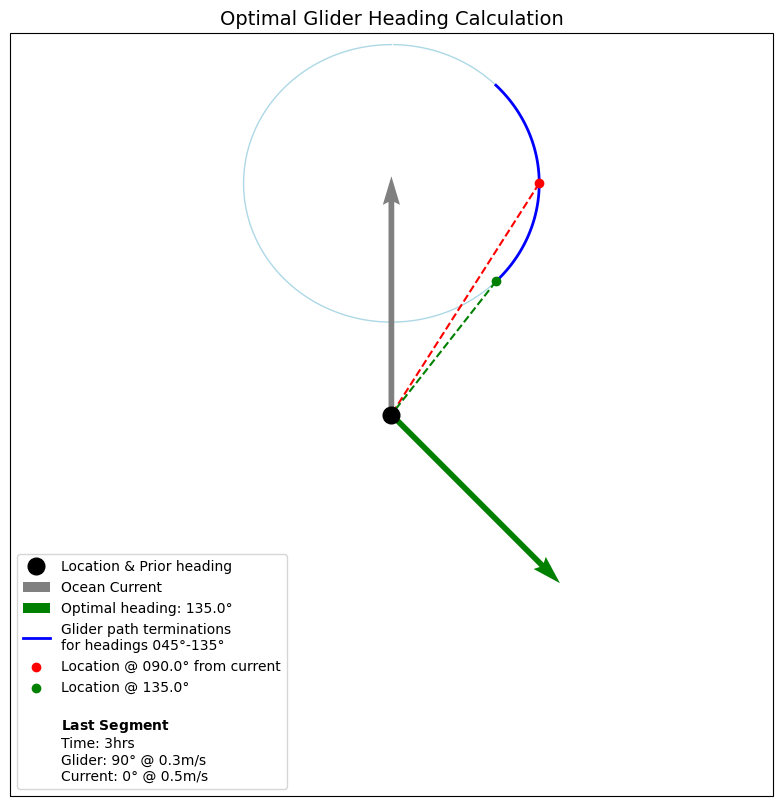

In [1]:
import numpy as np
import math # for function
from math import radians, sin, cos, sqrt, atan2
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def what_is_best_heading(underwater_time, m_avg_speed_mps, m_heading_rad, m_water_vel_dir_rad, m_water_vel_mag_mps):
    """
    Calculate the best heading based on input parameters.
    
    Parameters:
    - underwater_time (float): Time spent underwater in hours.
    - m_avg_speed_mps (float): Average speed of the glider in meters per second.
    - m_heading_rad (float): Glider's heading in radians.
    - m_water_vel_dir_rad (float): Water velocity direction in radians.
    - m_water_vel_mag_mps (float): Water velocity magnitude in meters per second.
    
    Returns:
    - final_vel_mag_mps (float): Magnitude of the final velocity in meters per second.
    - final_vel_dir_rad (float): Direction of the final velocity in radians.
    - deflection_distance_km (float): Distance glider would travel at the heading in km. 
    """
    # calculate estimated distance from time and speed
    # km = m/s * 60 for min * 60 for hour * hours underwater
    # est_distance_km = m_avg_speed_mps * 60 * 60 * underwater_time
    
    # glider vel components (horiz and vert)
    glider_vx_mps = m_avg_speed_mps * math.sin(m_heading_rad)  # m_heading is radians
    glider_vy_mps = m_avg_speed_mps * math.cos(m_heading_rad)  # take average of last x number somehow???

    # water vel components (horiz and vert)
    water_vx_mps = m_water_vel_mag_mps * math.sin(m_water_vel_dir_rad)  # m_water_vel_dir is radians
    water_vy_mps = m_water_vel_mag_mps * math.cos(m_water_vel_dir_rad)
    
    # combine glider and water velocities
    final_vx_mps = glider_vx_mps + water_vx_mps
    final_vy_mps = glider_vy_mps + water_vy_mps

    # calculate the magnitude of the resultant velocity
    final_vel_mag_mps = math.sqrt(final_vx_mps ** 2 + final_vy_mps ** 2)

    # calculate the direction of the resultant velocity
    final_vel_dir_rad = math.atan2(final_vy_mps, final_vx_mps)

    # what is new estimated distance?
    new_dist_m = final_vel_mag_mps * 3600 * underwater_time # underwater time to seconds

    # d=s*t --> t=d/s, used for calculating distance value
    deflect_time_sec = new_dist_m / final_vel_mag_mps

    # Calculate the deflection distance 
    deflection_distance_km = (final_vel_mag_mps * deflect_time_sec)/1000

    return final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km  # for km, returning magnitude and direction as well

# length of a degree of longitude at a given latitude
def lon_to_km(m_lat):
    # latitude from degrees to radians
    latitude_rad = math.radians(m_lat)
    # length of a degree of longitude
    length_of_lon = EARTH_RADIUS * math.cos(latitude_rad) * (math.pi / 180)
    return length_of_lon

# Function to calculate distance between two points using haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius_earth = 6371  # Radius of the Earth in kilometers
    distance = radius_earth * c  # Distance in kilometers
    return distance

# Constants for the conversion of degrees to distance (considering a simplified flat Earth)
EARTH_RADIUS = 6371    
LAT_TO_KM = 111.32  # 1 degree latitude = 111.32 km
LON_TO_KM = lon_to_km(20)    # use function to account for latitude of glider
         # Earth's radius in kilometers     


# Starting GPS location
start_latitude = 20  # in degrees
start_longitude = -86.5  # in degrees

m_dr_time = 3       # hours
m_avg_speed = 0.3  # m/s
m_heading_deg = 90  # deg
m_heading_rad = math.radians(m_heading_deg)  # Convert angle to radians
m_water_vel_dir_deg = 0 # deg
m_water_vel_dir_rad = math.radians(m_water_vel_dir_deg)
m_water_vel_mag = 0.5 # m/s

angles_deg = list(range(45,136))  # List of angles in degrees
angles_rad = [math.radians(angle_deg) for angle_deg in angles_deg]  # Convert angles to radians

angles_deg_all = list(range(1,361))  # List of ALL angles in degrees
angles_rad_all = [math.radians(angle_deg_all) for angle_deg_all in angles_deg_all]  # Convert angles to radians

# Initialize lists to hold data
final_vel_mag_mps_list = []
final_vel_dir_rad_list = []
deflection_distance_km_list = []
glider_positions_list = []

final_vel_mag_mps_list_all = []
final_vel_dir_rad_list_all = []
deflection_distance_km_list_all = []
glider_positions_list_all = []

# Calculate time and distance for angles_deg
for angle in angles_deg:
    theory_heading = math.radians(angle)
    final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
    final_vel_mag_mps_list.append(final_vel_mag_mps)  # Considering total distance traveled downstream
    final_vel_dir_rad_list.append(final_vel_dir_rad)
    deflection_distance_km_list.append(deflection_distance_km)

    current_distance = ((final_vel_mag_mps)*(m_dr_time*3600))/1000 # results in km
    glider_positions_list.append((current_distance * math.cos(final_vel_dir_rad) / LON_TO_KM + start_longitude,
                            current_distance * math.sin(final_vel_dir_rad) / LAT_TO_KM + start_latitude))

# Calculate time and distance for angles_deg_all
for angle in angles_deg_all:
    theory_heading = math.radians(angle)
    final_vel_mag_mps_all, final_vel_dir_rad_all, deflection_distance_km_all = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
    final_vel_mag_mps_list_all.append(final_vel_mag_mps_all)  # Considering total distance traveled downstream
    final_vel_dir_rad_list_all.append(final_vel_dir_rad_all)
    deflection_distance_km_list_all.append(deflection_distance_km_all)

    current_distance_all = ((final_vel_mag_mps_all)*(m_dr_time*3600))/1000 # results in km
    glider_positions_list_all.append((current_distance_all * math.cos(final_vel_dir_rad_all) / LON_TO_KM + start_longitude,
                            current_distance_all * math.sin(final_vel_dir_rad_all) / LAT_TO_KM + start_latitude))

# Create a DataFrame from the lists
data_from_function = pd.DataFrame({
    'final_vel_mag_mps': final_vel_mag_mps_list,
    'final_vel_dir_rad': final_vel_dir_rad_list,
    'deflection_distance_km': deflection_distance_km_list})

angles_index = pd.Index(angles_deg)

# Set the 'angles' list as the index of the DataFrame
data_from_function.index = angles_index

# Find the index of the minimum deflect distance
min_deflect_index_loc = data_from_function['deflection_distance_km'].idxmin()

# Retrieve the corresponding heading value
heading_with_min_deflection = min_deflect_index_loc
# NEEDS FLOAT BEFORE THE PATH PLOTTING
# Convert heading_with_min_deflection to a float value
heading_with_min_deflection_deg = float(heading_with_min_deflection)
heading_with_min_deflection_rad = math.radians(heading_with_min_deflection_deg)

glider_positions = pd.DataFrame(glider_positions_list,index=angles_index)   # put in dataframe

# theory_loc of glider if it flew true 90 deg from current @ glider speed
theory_m_heading = m_water_vel_dir_deg + 90
theory_dist = m_avg_speed * 3600 * m_dr_time # km

theory_lon = theory_dist * math.cos(theory_m_heading) / LON_TO_KM + start_longitude
theory_lat = theory_dist * math.sin(theory_m_heading) / LAT_TO_KM + start_latitude

# location of glider at 90 deg 
ninety_loc_lat = glider_positions.loc[90,1]
ninety_loc_lon = glider_positions.loc[90,0]

# location of glider at optimal heading 
optimal_loc_lat = glider_positions.loc[heading_with_min_deflection_deg,1]
optimal_loc_lon = glider_positions.loc[heading_with_min_deflection_deg,0]

# Calculate distances
distance_theory_ninety = round(haversine(theory_lon, theory_lat, ninety_loc_lon, ninety_loc_lat),1)
distance_theory_optimal = round(haversine(theory_lon, theory_lat, optimal_loc_lon, optimal_loc_lat),1)
diff = round(distance_theory_optimal-distance_theory_ninety,1)

# print("Distance between theory_loc and ninety_loc:",distance_theory_ninety,"km @ heading of 090.0)")
# print("Distance between theory_loc and optimal_loc:",distance_theory_optimal,f'km @ heading of {heading_with_min_deflection_deg}')
# print(f'Difference={diff}km')

# Creating a Cartopy map with Plate Carree projection
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the map extent
# ax.set_extent([-88, -84, 19, 22], crs=ccrs.PlateCarree())  # Adjusted extent to include more land

scale_arrows = 20
map_buff = 0.08
ax.set_extent([start_longitude-map_buff,
               start_longitude+map_buff,
               start_latitude+map_buff,
               start_latitude-map_buff
               ], crs=ccrs.PlateCarree())  # Adjusted extent to include more land

# Adding coastline, land, and other features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='burlywood',edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Plotting the starting point
ax.plot(start_longitude, start_latitude, 'ro',color='black', markersize=12,label=f'Location & Prior heading',zorder=9) #(86.5W, 21N)

# Convert m_heading to delta_lon and delta_lat
# delta_heading_lon = math.sin((m_heading_rad))
# delta_heading_lat = math.cos((m_heading_rad))

# # Plotting the m_heading vector originating from the starting point
# ax.quiver(start_longitude, start_latitude, delta_heading_lon, delta_heading_lat,
#           angles='uv', scale_units='xy', scale=scale_arrows, color='black',zorder=1)

delta_current_lon = math.sin(m_water_vel_dir_rad)
delta_current_lat = math.cos(m_water_vel_dir_rad)
# Plotting the current vector originating from the starting point
ax.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
          angles='uv', scale_units='xy', scale=scale_arrows, color='gray', label=f'Ocean Current',zorder=2)

# Convert heading_with_min_deflection to delta_lon and delta_lat for plotting
heading_delta_lon = math.sin(heading_with_min_deflection_rad)
heading_delta_lat = math.cos(heading_with_min_deflection_rad)

# Plotting the heading_with_min_deflection vector originating from the starting point
ax.quiver(start_longitude, start_latitude, heading_delta_lon, heading_delta_lat,
          angles='uv', scale_units='xy', scale=scale_arrows, color='green', label=f'Optimal heading: {heading_with_min_deflection:.1f}°',zorder=1)

# Plotting the location of the glider
path_lon, path_lat = zip(*glider_positions_list)
ax.plot(path_lon, path_lat, color='blue',linewidth=2,label=f'Glider path terminations\nfor headings 0{angles_deg[0]}°-{angles_deg[-1]}°',zorder=9)
#
path_lon_all, path_lat_all = zip(*glider_positions_list_all)
ax.plot(path_lon_all, path_lat_all, color='lightblue',linewidth=1,zorder=1)

# red dashed line and spot
ax.scatter(ninety_loc_lon,ninety_loc_lat,color='red',label='Location @ 090.0° from current',zorder=10)
ax.plot([ninety_loc_lon, start_longitude], [ninety_loc_lat, start_latitude],color='red',linestyle='--')

# green dashed line and spot
ax.scatter(optimal_loc_lon,optimal_loc_lat,color='green',label=f'Location @ {heading_with_min_deflection_deg}°',zorder=10)
ax.plot([optimal_loc_lon, start_longitude], [optimal_loc_lat, start_latitude],color='green',linestyle='--')

# ax.plot([ninety_loc_lon, optimal_loc_lon], [ninety_loc_lat, optimal_loc_lat],color='red',label=f'{abs(diff)}km difference')

# legend label
label=f'\n$\mathbf{{Last\ Segment}}$\nTime: {m_dr_time}hrs\nGlider: {m_heading_deg}° @ {m_avg_speed}m/s\nCurrent: {m_water_vel_dir_deg}° @ {m_water_vel_mag}m/s'
dummy_plot = ax.plot([], [], color='white', marker='', linestyle='-', label=label)

plt.title('Optimal Glider Heading Calculation',fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend(loc='lower left')
plt.tight_layout(pad=0.5)
plt.savefig('optimal_glider_heading_calc_cur0.png')

# IF OCEAN CURRENT IS NOT ON THE RIGHT SIDE THE 
# HEADING WITH MIN DEFLECTION NEEDS TO BE 
# COMPARED TO 270, NOT 90

# if the ocean current is a sector, do the math using proper angle NSEW
# 45-135
# 135-225
# 225-315
# 315-45

### Plot the main map and the above as the inset

C:\Users\Sophie\AppData\Local\Temp\ipykernel_22852\1790893201.py:409: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


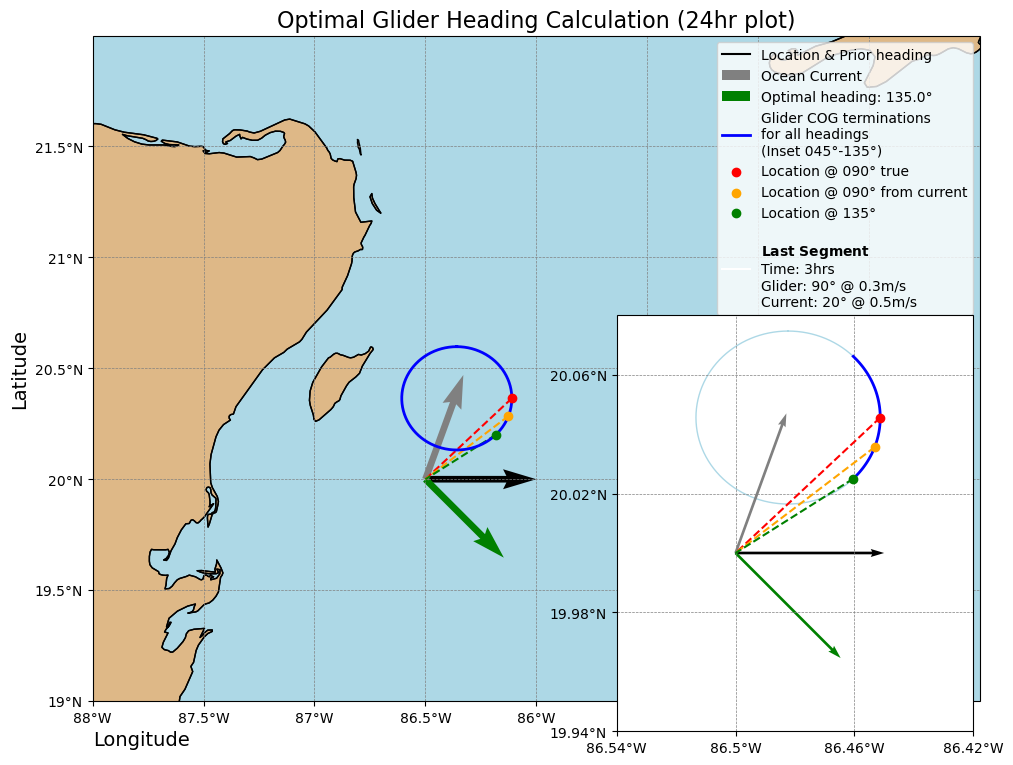

In [77]:
import numpy as np
import math
from math import radians, sin, cos, sqrt, atan2
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


#  ///
# <' \___/|
#  \_  _/
#    \ \
# THIS IS WHAT THE GLIDER UPDATES
# THIS IS WHAT THE GLIDER UPDATES
start_latitude = 20  # in degrees
start_longitude = -86.5  # in degrees

m_dr_time = 3       # hours
m_dr_time_12 = 24   # hours
m_avg_speed = 0.3   # m/s
m_heading_deg = 90  # deg
m_heading_rad = math.radians(m_heading_deg) # degrees to radians
m_water_vel_dir_deg = 20 # deg, MUST BE BETWEEN 335 and 90, until most_optimal_heading isn't as good as other headings, weird quadrant stuff
m_water_vel_dir_rad = math.radians(m_water_vel_dir_deg) # degrees to radians
m_water_vel_mag = 0.5 # m/s

# 270 - 45 - optimal heading
# 45 - 90 use 90 deg from current
# 90 - 270 - use heading of 90
##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### 

def what_is_best_heading(underwater_time, m_avg_speed_mps, m_heading_rad, m_water_vel_dir_rad, m_water_vel_mag_mps):
    """
    Calculate the best heading based on input parameters.
    
    Parameters:
    - underwater_time (float): Time spent underwater in hours.
    - m_avg_speed_mps (float): Average speed of the glider in meters per second.
    - m_heading_rad (float): Glider's heading in radians.
    - m_water_vel_dir_rad (float): Water velocity direction in radians.
    - m_water_vel_mag_mps (float): Water velocity magnitude in meters per second.
    
    Returns:
    - final_vel_mag_mps (float): Magnitude of the final velocity in meters per second.
    - final_vel_dir_rad (float): Direction of the final velocity in radians.
    - deflection_distance_km (float): Distance glider would travel at the heading in km. 
    """
    # calculate estimated distance from time and speed
    # km = m/s * 60 for min * 60 for hour * hours underwater
    # est_distance_km = m_avg_speed_mps * 60 * 60 * underwater_time
    
    # glider vel components (horiz and vert)
    glider_vx_mps = m_avg_speed_mps * math.sin(m_heading_rad)  # m_heading is radians
    glider_vy_mps = m_avg_speed_mps * math.cos(m_heading_rad)  # take average of last x number somehow???

    # water vel components (horiz and vert)
    water_vx_mps = m_water_vel_mag_mps * math.sin(m_water_vel_dir_rad)  # m_water_vel_dir is radians
    water_vy_mps = m_water_vel_mag_mps * math.cos(m_water_vel_dir_rad)
    
    # combine glider and water velocities
    final_vx_mps = glider_vx_mps + water_vx_mps
    final_vy_mps = glider_vy_mps + water_vy_mps

    # calculate the magnitude of the resultant velocity
    final_vel_mag_mps = math.sqrt(final_vx_mps ** 2 + final_vy_mps ** 2)

    # calculate the direction of the resultant velocity
    final_vel_dir_rad = math.atan2(final_vy_mps, final_vx_mps)

    # what is new estimated distance?
    new_dist_m = final_vel_mag_mps * 3600 * underwater_time # underwater time to seconds

    # d=s*t --> t=d/s, used for calculating distance value
    deflect_time_sec = new_dist_m / final_vel_mag_mps

    # Calculate the deflection distance 
    deflection_distance_km = (final_vel_mag_mps * deflect_time_sec)/1000

    return final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km  # for km, returning magnitude and direction as well

# length of a degree of longitude at a given latitude
def lon_to_km(m_lat):
    # latitude from degrees to radians
    latitude_rad = math.radians(m_lat)
    # length of a degree of longitude
    length_of_lon = EARTH_RADIUS * math.cos(latitude_rad) * (math.pi / 180)
    return length_of_lon

# Function to calculate distance between two points using haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius_earth = 6371  # Radius of the Earth in kilometers
    distance = radius_earth * c  # Distance in kilometers
    return distance

# Constants for the conversion of degrees to distance (considering a simplified flat Earth)
EARTH_RADIUS = 6371    
LAT_TO_KM = 111.32  # 1 degree latitude = 111.32 km
LON_TO_KM = lon_to_km(20)    # use function to account for latitude of glider
         # Earth's radius in kilometers    

angles_deg = list(range(45,136))  # list of angles, degrees
angles_rad = [math.radians(angle_deg) for angle_deg in angles_deg]  # degrees to radians

angles_deg_all = list(range(0,361))  # List of ALL angles in degrees
angles_rad_all = [math.radians(angle_deg_all) for angle_deg_all in angles_deg_all]  # degrees to radians

# Initialize lists to hold data
# there's a better way, but this works so *shrug*
final_vel_mag_mps_list = []
final_vel_dir_rad_list = []
deflection_distance_km_list = []
glider_positions_list = []

final_vel_mag_mps_list_all = []
final_vel_dir_rad_list_all = []
deflection_distance_km_list_all = []
glider_positions_list_all = []

final_vel_mag_mps_list_12 = []
final_vel_dir_rad_list_12 = []
deflection_distance_km_list_12 = []
glider_positions_list_12 = []

# Calculate time and distance for angles_deg
for angle in angles_deg:
    theory_heading = math.radians(angle)
    final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
    final_vel_mag_mps_list.append(final_vel_mag_mps)  # Considering total distance traveled downstream
    final_vel_dir_rad_list.append(final_vel_dir_rad)
    deflection_distance_km_list.append(deflection_distance_km)

    current_distance = ((final_vel_mag_mps)*(m_dr_time*3600))/1000 # results in km
    glider_positions_list.append((current_distance * math.cos(final_vel_dir_rad) / LON_TO_KM + start_longitude,
                            current_distance * math.sin(final_vel_dir_rad) / LAT_TO_KM + start_latitude))

# Calculate time and distance for angles_deg_all 
for angle in angles_deg_all:
    theory_heading = math.radians(angle)
    # last segment hours, for inset
    final_vel_mag_mps_all, final_vel_dir_rad_all, deflection_distance_km_all = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
    final_vel_mag_mps_list_all.append(final_vel_mag_mps_all)  # Considering total distance traveled downstream
    final_vel_dir_rad_list_all.append(final_vel_dir_rad_all)
    deflection_distance_km_list_all.append(deflection_distance_km_all)

    current_distance_all = ((final_vel_mag_mps_all)*(m_dr_time*3600))/1000 # results in km
    glider_positions_list_all.append((current_distance_all * math.cos(final_vel_dir_rad_all) / LON_TO_KM + start_longitude,
                            current_distance_all * math.sin(final_vel_dir_rad_all) / LAT_TO_KM + start_latitude))

    # 12 location plot
    final_vel_mag_mps_12, final_vel_dir_rad_12, deflection_distance_km_12 = what_is_best_heading(m_dr_time_12, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
    final_vel_mag_mps_list_12.append(final_vel_mag_mps_12)  # Considering total distance traveled downstream
    final_vel_dir_rad_list_12.append(final_vel_dir_rad_12)
    deflection_distance_km_list_12.append(deflection_distance_km_12)

    current_distance_12 = ((final_vel_mag_mps_12)*(m_dr_time_12*3600))/1000 # results in km
    glider_positions_list_12.append((current_distance_12 * math.cos(final_vel_dir_rad_12) / LON_TO_KM + start_longitude,
                            current_distance_12 * math.sin(final_vel_dir_rad_12) / LAT_TO_KM + start_latitude))

# DataFrame from the lists
three_hr_dataframe = pd.DataFrame({
    'final_vel_mag_mps': final_vel_mag_mps_list,
    'final_vel_dir_rad': final_vel_dir_rad_list,
    'deflection_distance_km': deflection_distance_km_list})

angles_index = pd.Index(angles_deg)
angles_index_12 = pd.Index(angles_deg_all)

# Set the 'angles' list as the index of the DataFrame
three_hr_dataframe.index = angles_index

# Find the index of the minimum deflect distance
min_deflect_index_loc = three_hr_dataframe['deflection_distance_km'].idxmin()

# Retrieve the corresponding heading value
heading_with_min_deflection = min_deflect_index_loc
# NEEDS FLOAT BEFORE THE PATH PLOTTING
# Convert heading_with_min_deflection to a float value
heading_with_min_deflection_deg = float(heading_with_min_deflection)
heading_with_min_deflection_rad = math.radians(heading_with_min_deflection_deg)

# theoretical heading 90 degrees from current
theory_m_heading = ((m_water_vel_dir_deg + 90) % 360)      

##### ##### ##### ##### ##### ##### 
##  THREE HOUR SEGMENT (INSET)
# theory_loc of glider if it flew true 90 deg from current @ glider speed

glider_positions = pd.DataFrame(glider_positions_list,index=angles_index)   # put in dataframe
glider_positions_all = pd.DataFrame(glider_positions_list_all,index=angles_index_12)   # put in dataframe
theory_dist = m_avg_speed * 3600 * m_dr_time    # km

theory_lon = theory_dist * math.cos(theory_m_heading) / LON_TO_KM + start_longitude
theory_lat = theory_dist * math.sin(theory_m_heading) / LAT_TO_KM + start_latitude

# location of glider at 90 deg true IRRESPECTIVE OF CURRENT
ninety_loc_lat = glider_positions.loc[90,1]
ninety_loc_lon = glider_positions.loc[90,0]

# location of glider at 90 deg from current (RED)
ninety_current_loc_lat = glider_positions_all.loc[theory_m_heading,1]
ninety_current_loc_lon = glider_positions_all.loc[theory_m_heading,0]

# location of glider at optimal heading (GREEN)
optimal_loc_lat = glider_positions.loc[heading_with_min_deflection_deg,1]
optimal_loc_lon = glider_positions.loc[heading_with_min_deflection_deg,0]

# Calculate distances
distance_theory_ninety = round(haversine(theory_lon, theory_lat, ninety_loc_lon, ninety_loc_lat),1)
distance_theory_optimal = round(haversine(theory_lon, theory_lat, optimal_loc_lon, optimal_loc_lat),1)
diff = abs(round(distance_theory_optimal-distance_theory_ninety,1) ) 


##### ##### ##### ##### ##### ##### 
## LONGER HOUR SEGMENT (BIG MAP)
# theory_loc of glider if it flew true 90 deg from current @ glider speed
glider_positions_list_12_df = pd.DataFrame(glider_positions_list_12,index=angles_index_12)   # put in dataframe
theory_dist_12 = m_avg_speed * 3600 * m_dr_time_12 # km

theory_lon = theory_dist_12 * math.cos(theory_m_heading) / LON_TO_KM + start_longitude
theory_lat = theory_dist_12 * math.sin(theory_m_heading) / LAT_TO_KM + start_latitude

# location of glider at 90 deg from current (RED)
ninety_true_loc_lat_12 = glider_positions_list_12_df.loc[90,1]
ninety_true_loc_lon_12 = glider_positions_list_12_df.loc[90,0]

# location of glider at 90 deg from current (RED)
ninety_loc_lat_12 = glider_positions_list_12_df.loc[theory_m_heading,1]
ninety_loc_lon_12 = glider_positions_list_12_df.loc[theory_m_heading,0]

# location of glider at optimal heading (GREEN)
optimal_loc_lat_12 = glider_positions_list_12_df.loc[heading_with_min_deflection_deg,1]
optimal_loc_lon_12 = glider_positions_list_12_df.loc[heading_with_min_deflection_deg,0]

# Calculate distances
distance_theory_ninety_12 = round(haversine(theory_lon, theory_lat, ninety_loc_lon_12, ninety_loc_lat_12),2)
distance_theory_optimal_12 = round(haversine(theory_lon, theory_lat, optimal_loc_lon_12, optimal_loc_lat_12),2)
diff_12 = abs(round(distance_theory_optimal_12-distance_theory_ninety_12,1))


##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### 
# Cartopy map with Plate Carree projection for larger map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Set the extent for the larger map
map_extent = [-88, -84, 19, 22]  # Adjust as needed
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

# Adding coastline, land, and other features to the larger map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='burlywood', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.set_facecolor('lightblue')

ax_inset = fig.add_axes([0.54, 0.06, 0.52, 0.52], projection=ccrs.PlateCarree())

map_buff = 0.08
inset_extent = [(start_longitude-0.04),
               (start_longitude+map_buff),
               (start_latitude+map_buff),
               (start_latitude-0.06)
               ]
ax_inset.set_extent(inset_extent, crs=ccrs.PlateCarree())  # Adjusted extent to include more land

# Scales for all arrows
scale_arrows = 2
scale_arrows_inset = 20

##### ##### ##### ##### ##### ##### 
# LOCATION OF GLIDER
ax.plot(start_longitude, start_latitude,color='black', markersize=6,label=f'Location & Prior heading',zorder=9) #(86.5W, 21N)
ax_inset.plot(start_longitude, start_latitude,color='black', markersize=4,zorder=9) #(86.5W, 21N)
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# BLACK ARROW - prior heading 
# Convert m_heading to delta_lon and delta_lat
delta_heading_lon = math.sin((m_heading_rad))   # gotta be rad bro *hang loose*
delta_heading_lat = math.cos((m_heading_rad))   # radians

# Plotting the m_heading vector originating from the starting point
ax.quiver(start_longitude, start_latitude, delta_heading_lon, delta_heading_lat,
          angles='uv', scale_units='xy', scale=scale_arrows, color='black',zorder=1)
ax_inset.quiver(start_longitude, start_latitude, delta_heading_lon, delta_heading_lat,
          angles='uv', scale_units='xy', scale=scale_arrows_inset, color='black',zorder=1)
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# GRAY ARROW - current vector
delta_current_lon = math.sin(m_water_vel_dir_rad)
delta_current_lat = math.cos(m_water_vel_dir_rad)
# Plotting the current vector originating from the starting point
ax.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
          angles='uv', scale_units='xy', scale=scale_arrows, color='gray', label=f'Ocean Current',zorder=2)
ax_inset.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
          angles='uv', scale_units='xy', scale=scale_arrows_inset, color='gray',zorder=2)
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# BIG GREEN ARROW - heading with min deflection
# Convert heading_with_min_deflection to delta_lon and delta_lat for plotting
heading_delta_lon = math.sin(heading_with_min_deflection_rad)
heading_delta_lat = math.cos(heading_with_min_deflection_rad)

# Plotting the heading_with_min_deflection vector originating from the starting point
ax.quiver(start_longitude, start_latitude, heading_delta_lon, heading_delta_lat,
          angles='uv', scale_units='xy', scale=scale_arrows, color='green', label=f'Optimal heading: {heading_with_min_deflection:.1f}°',zorder=1)
# Plotting the heading_with_min_deflection vector originating from the starting point
ax_inset.quiver(start_longitude, start_latitude, heading_delta_lon, heading_delta_lat,
          angles='uv', scale_units='xy', scale=scale_arrows_inset, color='green',zorder=1)
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# BIG MAP location of the glider (blue circle representing all possible terminations of COG based on headings)
path_lon_map, path_lat_map = zip(*glider_positions_list_12)
ax.plot(path_lon_map, path_lat_map, color='blue',linewidth=2,label=f'Glider COG terminations\nfor all headings\n(Inset 0{angles_deg[0]}°-{angles_deg[-1]}°)',zorder=9)

# INSET 
# plot all angles possible circle in light blue
path_lon_inset_all, path_lat_inset_all = zip(*glider_positions_list_all)
ax_inset.plot(path_lon_inset_all, path_lat_inset_all, color='lightblue',linewidth=1,zorder=1)

# plot only angles 045-135 in darker blue
path_lon_inset, path_lat_inset = zip(*glider_positions_list)
ax_inset.plot(path_lon_inset, path_lat_inset, color='blue',linewidth=2,zorder=9) #label=f'Glider path terminations\nfor headings 0{angles_deg[0]}°-{angles_deg[-1]}°'
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# BIG MAP
# RED: 90deg true east
ax.scatter(ninety_true_loc_lon_12,ninety_true_loc_lat_12,label='Location @ 090° true',color='red',zorder=10) # ONLY FOR LEGEND
ax.plot([ninety_true_loc_lon_12, start_longitude], [ninety_true_loc_lat_12, start_latitude],color='red',linestyle='--')

# ORANGE: 90deg from current
ax.scatter(ninety_loc_lon_12,ninety_loc_lat_12,color='orange',label='Location @ 090° from current',zorder=10)
ax.plot([ninety_loc_lon_12, start_longitude], [ninety_loc_lat_12, start_latitude],color='orange',linestyle='--')

# GREEN: 
ax.scatter(optimal_loc_lon_12,optimal_loc_lat_12,color='green',label=f'Location @ {int(heading_with_min_deflection_deg)}°',zorder=10)
ax.plot([optimal_loc_lon_12, start_longitude], [optimal_loc_lat_12, start_latitude],color='green',linestyle='--')
##### ##### ##### ##### ##### ##### 


##### ##### ##### ##### ##### ##### 
# INSET
# RED: 90deg true east
ax_inset.scatter(ninety_loc_lon,ninety_loc_lat,color='red',zorder=10)
ax_inset.plot([ninety_loc_lon, start_longitude], [ninety_loc_lat, start_latitude],color='red',linestyle='--')

# ORANGE: 90deg from current
ax_inset.scatter(ninety_current_loc_lon,ninety_current_loc_lat,color='orange',zorder=10)
ax_inset.plot([ninety_current_loc_lon, start_longitude], [ninety_current_loc_lat, start_latitude],color='orange',linestyle='--')

# GREEN: optimal heading location
ax_inset.scatter(optimal_loc_lon,optimal_loc_lat,color='green',zorder=10)
ax_inset.plot([optimal_loc_lon, start_longitude], [optimal_loc_lat, start_latitude],color='green',linestyle='--')
##### ##### ##### ##### ##### ##### 


# legend label
label=f'\n$\mathbf{{Last\ Segment}}$\nTime: {m_dr_time}hrs\nGlider: {m_heading_deg}° @ {m_avg_speed}m/s\nCurrent: {m_water_vel_dir_deg}° @ {m_water_vel_mag}m/s'
dummy_plot = ax.plot([], [], color='white', marker='', linestyle='-', label=label)


ax.set_title(f'Optimal Glider Heading Calculation ({m_dr_time_12}hr plot)',fontsize=16)
ax.set_xlabel('Longitude',x=0,ha='left',fontsize=14)
ax.set_ylabel('Latitude',fontsize=14)
ax.legend()

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# main
ax.grid(True, linestyle='--', color='gray', linewidth=0.5, zorder=3)
# Set tick labels for longitude and latitude
ax.set_xticks(np.arange(map_extent[0], map_extent[1], 0.5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(map_extent[2], map_extent[3], 0.5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


# inset
ax_inset.grid(True, linestyle='--', color='gray', linewidth=0.5, zorder=3)
# Set tick labels for longitude and latitude
ax_inset.set_xticks(np.arange(inset_extent[0], inset_extent[1], 0.04), crs=ccrs.PlateCarree())
ax_inset.set_yticks(np.arange(inset_extent[3], inset_extent[2], 0.04), crs=ccrs.PlateCarree())
ax_inset.xaxis.set_major_formatter(lon_formatter)
ax_inset.yaxis.set_major_formatter(lat_formatter)

plt.tight_layout()
plt.savefig('Optimal_Glider_Heading_Calculation.png')

### The distane per heading makes a nice wave

Text(0.5, 0, 'heading')

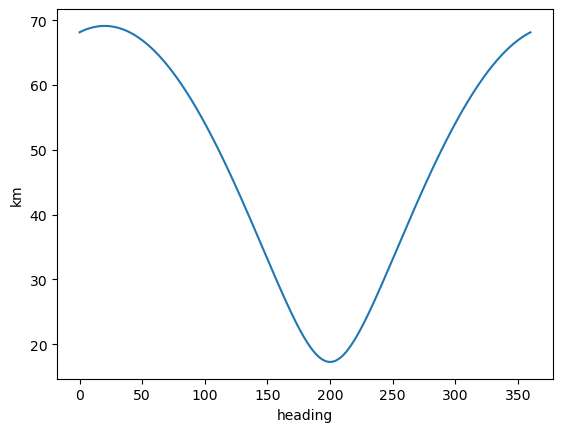

In [38]:
plt.plot(angles_deg_all,deflection_distance_km_list_12)
plt.ylabel('km')
plt.xlabel('heading')

### These are used to make the .mp4 files in this folder

In [1]:
# # uncomment this to save a bunch of images to put together into an animation
# # used to make the .mp4 animations in this folder

# import numpy as np
# import math
# from math import radians, sin, cos, sqrt, atan2
# import pandas as pd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import warnings
# warnings.filterwarnings('ignore')


# #  ///
# # <' \___/|
# #  \_  _/
# #    \ \
# # THIS IS WHAT THE GLIDER UPDATES
# # THIS IS WHAT THE GLIDER UPDATES
# start_latitude = 20  # in degrees
# start_longitude = -86.5  # in degrees

# m_dr_time = 3       # hours
# m_dr_time_12 = 24   # hours
# m_avg_speed = 0.3   # m/s
# m_heading_deg = 90  # deg
# m_heading_rad = math.radians(m_heading_deg) # degrees to radians
# m_water_vel_dir_deg = 0 # deg, MUST BE BETWEEN 335 and 205

# count = 0
# while m_water_vel_dir_deg < 361:


    
#     m_water_vel_dir_rad = math.radians(m_water_vel_dir_deg) # degrees to radians
#     m_water_vel_mag = 0.5 # m/s



#     ##### ##### ##### ##### ##### ##### 
#     ##### ##### ##### ##### ##### ##### 
#     ##### ##### ##### ##### ##### ##### 

#     def what_is_best_heading(underwater_time, m_avg_speed_mps, m_heading_rad, m_water_vel_dir_rad, m_water_vel_mag_mps):
#         """
#         Calculate the best heading based on input parameters.
        
#         Parameters:
#         - underwater_time (float): Time spent underwater in hours.
#         - m_avg_speed_mps (float): Average speed of the glider in meters per second.
#         - m_heading_rad (float): Glider's heading in radians.
#         - m_water_vel_dir_rad (float): Water velocity direction in radians.
#         - m_water_vel_mag_mps (float): Water velocity magnitude in meters per second.
        
#         Returns:
#         - final_vel_mag_mps (float): Magnitude of the final velocity in meters per second.
#         - final_vel_dir_rad (float): Direction of the final velocity in radians.
#         - deflection_distance_km (float): Distance glider would travel at the heading in km. 
#         """
#         # calculate estimated distance from time and speed
#         # km = m/s * 60 for min * 60 for hour * hours underwater
#         # est_distance_km = m_avg_speed_mps * 60 * 60 * underwater_time
        
#         # glider vel components (horiz and vert)
#         glider_vx_mps = m_avg_speed_mps * math.sin(m_heading_rad)  # m_heading is radians
#         glider_vy_mps = m_avg_speed_mps * math.cos(m_heading_rad)  # take average of last x number somehow???

#         # water vel components (horiz and vert)
#         water_vx_mps = m_water_vel_mag_mps * math.sin(m_water_vel_dir_rad)  # m_water_vel_dir is radians
#         water_vy_mps = m_water_vel_mag_mps * math.cos(m_water_vel_dir_rad)
        
#         # combine glider and water velocities
#         final_vx_mps = glider_vx_mps + water_vx_mps
#         final_vy_mps = glider_vy_mps + water_vy_mps

#         # calculate the magnitude of the resultant velocity
#         final_vel_mag_mps = math.sqrt(final_vx_mps ** 2 + final_vy_mps ** 2)

#         # calculate the direction of the resultant velocity
#         final_vel_dir_rad = math.atan2(final_vy_mps, final_vx_mps)

#         # what is new estimated distance?
#         new_dist_m = final_vel_mag_mps * 3600 * underwater_time # underwater time to seconds

#         # d=s*t --> t=d/s, used for calculating distance value
#         deflect_time_sec = new_dist_m / final_vel_mag_mps

#         # Calculate the deflection distance 
#         deflection_distance_km = (final_vel_mag_mps * deflect_time_sec)/1000

#         return final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km  # for km, returning magnitude and direction as well

#     # length of a degree of longitude at a given latitude
#     def lon_to_km(m_lat):
#         # latitude from degrees to radians
#         latitude_rad = math.radians(m_lat)
#         # length of a degree of longitude
#         length_of_lon = EARTH_RADIUS * math.cos(latitude_rad) * (math.pi / 180)
#         return length_of_lon

#     # Function to calculate distance between two points using haversine formula
#     def haversine(lon1, lat1, lon2, lat2):
#         # Convert latitude and longitude from degrees to radians
#         lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

#         # Haversine formula
#         dlon = lon2 - lon1
#         dlat = lat2 - lat1
#         a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
#         c = 2 * atan2(sqrt(a), sqrt(1 - a))
#         radius_earth = 6371  # Radius of the Earth in kilometers
#         distance = radius_earth * c  # Distance in kilometers
#         return distance

#     # Constants for the conversion of degrees to distance (considering a simplified flat Earth)
#     EARTH_RADIUS = 6371    
#     LAT_TO_KM = 111.32  # 1 degree latitude = 111.32 km
#     LON_TO_KM = lon_to_km(20)    # use function to account for latitude of glider
#             # Earth's radius in kilometers    

#     angles_deg = list(range(45,136))  # list of angles, degrees
#     angles_rad = [math.radians(angle_deg) for angle_deg in angles_deg]  # degrees to radians

#     angles_deg_all = list(range(0,361))  # List of ALL angles in degrees
#     angles_rad_all = [math.radians(angle_deg_all) for angle_deg_all in angles_deg_all]  # degrees to radians

#     # Initialize lists to hold data
#     # there's a better way, but this works so *shrug*
#     final_vel_mag_mps_list = []
#     final_vel_dir_rad_list = []
#     deflection_distance_km_list = []
#     glider_positions_list = []

#     final_vel_mag_mps_list_all = []
#     final_vel_dir_rad_list_all = []
#     deflection_distance_km_list_all = []
#     glider_positions_list_all = []

#     final_vel_mag_mps_list_12 = []
#     final_vel_dir_rad_list_12 = []
#     deflection_distance_km_list_12 = []
#     glider_positions_list_12 = []



#     # Calculate time and distance for angles_deg
#     for angle in angles_deg:
#         theory_heading = math.radians(angle)
#         final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
#         final_vel_mag_mps_list.append(final_vel_mag_mps)  # Considering total distance traveled downstream
#         final_vel_dir_rad_list.append(final_vel_dir_rad)
#         deflection_distance_km_list.append(deflection_distance_km)

#         current_distance = ((final_vel_mag_mps)*(m_dr_time*3600))/1000 # results in km
#         glider_positions_list.append((current_distance * math.cos(final_vel_dir_rad) / LON_TO_KM + start_longitude,
#                                 current_distance * math.sin(final_vel_dir_rad) / LAT_TO_KM + start_latitude))

#     # Calculate time and distance for angles_deg_all 
#     for angle in angles_deg_all:
#         theory_heading = math.radians(angle)
#         # last segment hours, for inset
#         final_vel_mag_mps_all, final_vel_dir_rad_all, deflection_distance_km_all = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
#         final_vel_mag_mps_list_all.append(final_vel_mag_mps_all)  # Considering total distance traveled downstream
#         final_vel_dir_rad_list_all.append(final_vel_dir_rad_all)
#         deflection_distance_km_list_all.append(deflection_distance_km_all)

#         current_distance_all = ((final_vel_mag_mps_all)*(m_dr_time*3600))/1000 # results in km
#         glider_positions_list_all.append((current_distance_all * math.cos(final_vel_dir_rad_all) / LON_TO_KM + start_longitude,
#                                 current_distance_all * math.sin(final_vel_dir_rad_all) / LAT_TO_KM + start_latitude))

#         # 12 location plot
#         final_vel_mag_mps_12, final_vel_dir_rad_12, deflection_distance_km_12 = what_is_best_heading(m_dr_time_12, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
#         final_vel_mag_mps_list_12.append(final_vel_mag_mps_12)  # Considering total distance traveled downstream
#         final_vel_dir_rad_list_12.append(final_vel_dir_rad_12)
#         deflection_distance_km_list_12.append(deflection_distance_km_12)

#         current_distance_12 = ((final_vel_mag_mps_12)*(m_dr_time_12*3600))/1000 # results in km
#         glider_positions_list_12.append((current_distance_12 * math.cos(final_vel_dir_rad_12) / LON_TO_KM + start_longitude,
#                                 current_distance_12 * math.sin(final_vel_dir_rad_12) / LAT_TO_KM + start_latitude))

#     # DataFrame from the lists
#     three_hr_dataframe = pd.DataFrame({
#         'final_vel_mag_mps': final_vel_mag_mps_list,
#         'final_vel_dir_rad': final_vel_dir_rad_list,
#         'deflection_distance_km': deflection_distance_km_list})

#     angles_index = pd.Index(angles_deg)
#     angles_index_12 = pd.Index(angles_deg_all)

#     # Set the 'angles' list as the index of the DataFrame
#     three_hr_dataframe.index = angles_index

#     # Find the index of the minimum deflect distance
#     min_deflect_index_loc = three_hr_dataframe['deflection_distance_km'].idxmin()

#     # Retrieve the corresponding heading value
#     heading_with_min_deflection = min_deflect_index_loc
#     # NEEDS FLOAT BEFORE THE PATH PLOTTING
#     # Convert heading_with_min_deflection to a float value
#     heading_with_min_deflection_deg = float(heading_with_min_deflection)
#     heading_with_min_deflection_rad = math.radians(heading_with_min_deflection_deg)

#     # theoretical heading 90 degrees from current
#     theory_m_heading = ((m_water_vel_dir_deg + 90) % 360)      

#     ##### ##### ##### ##### ##### ##### 
#     ##  THREE HOUR SEGMENT (INSET)
#     # theory_loc of glider if it flew true 90 deg from current @ glider speed

#     glider_positions = pd.DataFrame(glider_positions_list,index=angles_index)   # put in dataframe
#     glider_positions_all = pd.DataFrame(glider_positions_list_all,index=angles_index_12)   # put in dataframe
#     theory_dist = m_avg_speed * 3600 * m_dr_time    # km

#     theory_lon = theory_dist * math.cos(theory_m_heading) / LON_TO_KM + start_longitude
#     theory_lat = theory_dist * math.sin(theory_m_heading) / LAT_TO_KM + start_latitude

#     # location of glider at 90 deg true IRRESPECTIVE OF CURRENT
#     ninety_loc_lat = glider_positions.loc[90,1]
#     ninety_loc_lon = glider_positions.loc[90,0]

#     # location of glider at 90 deg from current (RED)
#     ninety_current_loc_lat = glider_positions_all.loc[theory_m_heading,1]
#     ninety_current_loc_lon = glider_positions_all.loc[theory_m_heading,0]

#     # location of glider at optimal heading (GREEN)
#     optimal_loc_lat = glider_positions.loc[heading_with_min_deflection_deg,1]
#     optimal_loc_lon = glider_positions.loc[heading_with_min_deflection_deg,0]

#     # Calculate distances
#     distance_theory_ninety = round(haversine(theory_lon, theory_lat, ninety_loc_lon, ninety_loc_lat),1)
#     distance_theory_optimal = round(haversine(theory_lon, theory_lat, optimal_loc_lon, optimal_loc_lat),1)
#     diff = abs(round(distance_theory_optimal-distance_theory_ninety,1) ) 


#     ##### ##### ##### ##### ##### ##### 
#     ## LONGER HOUR SEGMENT (BIG MAP)
#     # theory_loc of glider if it flew true 90 deg from current @ glider speed
#     glider_positions_list_12_df = pd.DataFrame(glider_positions_list_12,index=angles_index_12)   # put in dataframe
#     theory_dist_12 = m_avg_speed * 3600 * m_dr_time_12 # km

#     theory_lon = theory_dist_12 * math.cos(theory_m_heading) / LON_TO_KM + start_longitude
#     theory_lat = theory_dist_12 * math.sin(theory_m_heading) / LAT_TO_KM + start_latitude

#     # location of glider at 90 deg from current (RED)
#     ninety_true_loc_lat_12 = glider_positions_list_12_df.loc[90,1]
#     ninety_true_loc_lon_12 = glider_positions_list_12_df.loc[90,0]

#     # location of glider at 90 deg from current (RED)
#     ninety_loc_lat_12 = glider_positions_list_12_df.loc[theory_m_heading,1]
#     ninety_loc_lon_12 = glider_positions_list_12_df.loc[theory_m_heading,0]

#     # location of glider at optimal heading (GREEN)
#     optimal_loc_lat_12 = glider_positions_list_12_df.loc[heading_with_min_deflection_deg,1]
#     optimal_loc_lon_12 = glider_positions_list_12_df.loc[heading_with_min_deflection_deg,0]

#     # Calculate distances
#     distance_theory_ninety_12 = round(haversine(theory_lon, theory_lat, ninety_loc_lon_12, ninety_loc_lat_12),2)
#     distance_theory_optimal_12 = round(haversine(theory_lon, theory_lat, optimal_loc_lon_12, optimal_loc_lat_12),2)
#     diff_12 = abs(round(distance_theory_optimal_12-distance_theory_ninety_12,1))



#     ##### ##### ##### ##### ##### ##### 
#     ##### ##### ##### ##### ##### ##### 
#     # Cartopy map with Plate Carree projection for larger map
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#     # Set the extent for the larger map
#     map_extent = [-88, -84, 19, 22]  # Adjust as needed
#     ax.set_extent(map_extent, crs=ccrs.PlateCarree())

#     # Adding coastline, land, and other features to the larger map
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.LAND, facecolor='burlywood', edgecolor='black')
#     ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
#     ax.set_facecolor('lightblue')

#     ax_inset = fig.add_axes([0.54, 0.06, 0.52, 0.52], projection=ccrs.PlateCarree())

#     map_buff = 0.08
#     ax_inset.set_extent([start_longitude-0.04,
#                 start_longitude+map_buff,
#                 start_latitude+map_buff,
#                 start_latitude-0.06
#                 ], crs=ccrs.PlateCarree())  # Adjusted extent to include more land

#     # Scales for all arrows
#     scale_arrows = 2
#     scale_arrows_inset = 20

#     ##### ##### ##### ##### ##### ##### 
#     # LOCATION OF GLIDER
#     ax.plot(start_longitude, start_latitude,color='black', markersize=6,label=f'Location & Prior heading',zorder=9) #(86.5W, 21N)
#     ax_inset.plot(start_longitude, start_latitude,color='black', markersize=4,zorder=9) #(86.5W, 21N)
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # BLACK ARROW - prior heading 
#     # Convert m_heading to delta_lon and delta_lat
#     delta_heading_lon = math.sin((m_heading_rad))   # gotta be rad bro *hang loose*
#     delta_heading_lat = math.cos((m_heading_rad))   # radians

#     # Plotting the m_heading vector originating from the starting point
#     ax.quiver(start_longitude, start_latitude, delta_heading_lon, delta_heading_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows, color='black',zorder=1)
#     ax_inset.quiver(start_longitude, start_latitude, delta_heading_lon, delta_heading_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows_inset, color='black',zorder=1)
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # GRAY ARROW - current vector
#     delta_current_lon = math.sin(m_water_vel_dir_rad)
#     delta_current_lat = math.cos(m_water_vel_dir_rad)
#     # Plotting the current vector originating from the starting point
#     ax.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows, color='gray', label=f'Ocean Current',zorder=2)
#     ax_inset.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows_inset, color='gray',zorder=2)
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # BIG GREEN ARROW - heading with min deflection
#     # Convert heading_with_min_deflection to delta_lon and delta_lat for plotting
#     heading_delta_lon = math.sin(heading_with_min_deflection_rad)
#     heading_delta_lat = math.cos(heading_with_min_deflection_rad)

#     # Plotting the heading_with_min_deflection vector originating from the starting point
#     ax.quiver(start_longitude, start_latitude, heading_delta_lon, heading_delta_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows, color='green', label=f'Optimal heading: {heading_with_min_deflection:.1f}°',zorder=1)
#     # Plotting the heading_with_min_deflection vector originating from the starting point
#     ax_inset.quiver(start_longitude, start_latitude, heading_delta_lon, heading_delta_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows_inset, color='green',zorder=1)
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # BIG MAP location of the glider (blue circle representing all possible terminations of COG based on headings)
#     path_lon_map, path_lat_map = zip(*glider_positions_list_12)
#     ax.plot(path_lon_map, path_lat_map, color='blue',linewidth=2,label=f'Glider path terminations\nfor all headings\n(Inset 0{angles_deg[0]}°-{angles_deg[-1]}°)',zorder=9)

#     # INSET 
#     # plot all angles possible circle in light blue
#     path_lon_inset_all, path_lat_inset_all = zip(*glider_positions_list_all)
#     ax_inset.plot(path_lon_inset_all, path_lat_inset_all, color='lightblue',linewidth=1,zorder=1)

#     # plot only angles 045-135 in darker blue
#     path_lon_inset, path_lat_inset = zip(*glider_positions_list)
#     ax_inset.plot(path_lon_inset, path_lat_inset, color='blue',linewidth=2,zorder=9) #label=f'Glider path terminations\nfor headings 0{angles_deg[0]}°-{angles_deg[-1]}°'
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # BIG MAP
#     # RED: 90deg true east
#     ax.scatter(ninety_true_loc_lon_12,ninety_true_loc_lat_12,label='Location @ 090° true',color='red',zorder=10) # ONLY FOR LEGEND
#     ax.plot([ninety_true_loc_lon_12, start_longitude], [ninety_true_loc_lat_12, start_latitude],color='red',linestyle='--')

#     # ORANGE: 90deg from current
#     ax.scatter(ninety_loc_lon_12,ninety_loc_lat_12,color='orange',label='Location @ 090° from current',zorder=10)
#     ax.plot([ninety_loc_lon_12, start_longitude], [ninety_loc_lat_12, start_latitude],color='orange',linestyle='--')

#     # GREEN: 
#     ax.scatter(optimal_loc_lon_12,optimal_loc_lat_12,color='green',label=f'Location @ {int(heading_with_min_deflection_deg)}°',zorder=10)
#     ax.plot([optimal_loc_lon_12, start_longitude], [optimal_loc_lat_12, start_latitude],color='green',linestyle='--')
#     ##### ##### ##### ##### ##### ##### 


#     ##### ##### ##### ##### ##### ##### 
#     # INSET
#     # RED: 90deg true east
#     ax_inset.scatter(ninety_loc_lon,ninety_loc_lat,color='red',zorder=10)
#     ax_inset.plot([ninety_loc_lon, start_longitude], [ninety_loc_lat, start_latitude],color='red',linestyle='--')

#     # ORANGE: 90deg from current
#     ax_inset.scatter(ninety_current_loc_lon,ninety_current_loc_lat,color='orange',zorder=10)
#     ax_inset.plot([ninety_current_loc_lon, start_longitude], [ninety_current_loc_lat, start_latitude],color='orange',linestyle='--')

#     # GREEN: optimal heading location
#     ax_inset.scatter(optimal_loc_lon,optimal_loc_lat,color='green',zorder=10)
#     ax_inset.plot([optimal_loc_lon, start_longitude], [optimal_loc_lat, start_latitude],color='green',linestyle='--')
#     ##### ##### ##### ##### ##### ##### 


#     # legend label
#     label=f'\n$\mathbf{{Last\ Segment}}$\nTime: {m_dr_time}hrs\nGlider: {m_heading_deg}° @ {m_avg_speed}m/s\nCurrent: {m_water_vel_dir_deg}° @ {m_water_vel_mag}m/s'
#     dummy_plot = ax.plot([], [], color='white', marker='', linestyle='-', label=label)

#     ax.set_title(f'Optimal Glider Heading Calculation ({m_dr_time_12}hr plot)',fontsize=14)
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.legend()
#     plt.tight_layout()
#     plt.savefig(f'../c_bsd_crosscurrent/exports/{count}_glider_plotz.png')
#     count = count + 1
#     m_water_vel_dir_deg = m_water_vel_dir_deg + 1

In [3]:
# # used to make the static current, moving heading .mp4 example in this heading, for explaining 

# import numpy as np
# import math
# from math import radians, sin, cos, sqrt, atan2
# import pandas as pd
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import warnings
# warnings.filterwarnings('ignore')


# #  ///
# # <' \___/|
# #  \_  _/
# #    \ \
# # THIS IS WHAT THE GLIDER UPDATES
# # THIS IS WHAT THE GLIDER UPDATES
# start_latitude = 20  # in degrees
# start_longitude = -86.5  # in degrees

# m_dr_time = 24       # hours
# m_avg_speed = 0.3   # m/s
# m_heading_deg = 90  # deg
# m_heading_rad = math.radians(m_heading_deg) # degrees to radians
# m_water_vel_dir_deg = 45 # deg, MUST BE BETWEEN 335 and 205
# m_water_vel_dir_rad = math.radians(m_water_vel_dir_deg) # degrees to radians
# m_water_vel_mag = 0.5 # m/s

# count = 0
# glider_heading = 0
# while count < 361:

#     def what_is_best_heading(underwater_time, m_avg_speed_mps, m_heading_rad, m_water_vel_dir_rad, m_water_vel_mag_mps):
#         """
#         Calculate the best heading based on input parameters.
        
#         Parameters:
#         - underwater_time (float): Time spent underwater in hours.
#         - m_avg_speed_mps (float): Average speed of the glider in meters per second.
#         - m_heading_rad (float): Glider's heading in radians.
#         - m_water_vel_dir_rad (float): Water velocity direction in radians.
#         - m_water_vel_mag_mps (float): Water velocity magnitude in meters per second.
        
#         Returns:
#         - final_vel_mag_mps (float): Magnitude of the final velocity in meters per second.
#         - final_vel_dir_rad (float): Direction of the final velocity in radians.
#         - deflection_distance_km (float): Distance glider would travel at the heading in km. 
#         """
#         # calculate estimated distance from time and speed
#         # km = m/s * 60 for min * 60 for hour * hours underwater
#         # est_distance_km = m_avg_speed_mps * 60 * 60 * underwater_time
        
#         # glider vel components (horiz and vert)
#         glider_vx_mps = m_avg_speed_mps * math.sin(m_heading_rad)  # m_heading is radians
#         glider_vy_mps = m_avg_speed_mps * math.cos(m_heading_rad)  # take average of last x number somehow???

#         # water vel components (horiz and vert)
#         water_vx_mps = m_water_vel_mag_mps * math.sin(m_water_vel_dir_rad)  # m_water_vel_dir is radians
#         water_vy_mps = m_water_vel_mag_mps * math.cos(m_water_vel_dir_rad)
        
#         # combine glider and water velocities
#         final_vx_mps = glider_vx_mps + water_vx_mps
#         final_vy_mps = glider_vy_mps + water_vy_mps

#         # calculate the magnitude of the resultant velocity
#         final_vel_mag_mps = math.sqrt(final_vx_mps ** 2 + final_vy_mps ** 2)

#         # calculate the direction of the resultant velocity
#         final_vel_dir_rad = math.atan2(final_vy_mps, final_vx_mps)

#         # what is new estimated distance?
#         new_dist_m = final_vel_mag_mps * 3600 * underwater_time # underwater time to seconds

#         # d=s*t --> t=d/s, used for calculating distance value
#         deflect_time_sec = new_dist_m / final_vel_mag_mps

#         # Calculate the deflection distance 
#         deflection_distance_km = (final_vel_mag_mps * deflect_time_sec)/1000

#         return final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km  # for km, returning magnitude and direction as well

#     # length of a degree of longitude at a given latitude
#     def lon_to_km(m_lat):
#         # latitude from degrees to radians
#         latitude_rad = math.radians(m_lat)
#         # length of a degree of longitude
#         length_of_lon = EARTH_RADIUS * math.cos(latitude_rad) * (math.pi / 180)
#         return length_of_lon

#     # Function to calculate distance between two points using haversine formula
#     def haversine(lon1, lat1, lon2, lat2):
#         # Convert latitude and longitude from degrees to radians
#         lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

#         # Haversine formula
#         dlon = lon2 - lon1
#         dlat = lat2 - lat1
#         a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
#         c = 2 * atan2(sqrt(a), sqrt(1 - a))
#         radius_earth = 6371  # Radius of the Earth in kilometers
#         distance = radius_earth * c  # Distance in kilometers
#         return distance

#     # Constants for the conversion of degrees to distance (considering a simplified flat Earth)
#     EARTH_RADIUS = 6371    
#     LAT_TO_KM = 111.32  # 1 degree latitude = 111.32 km
#     LON_TO_KM = lon_to_km(20)    # use function to account for latitude of glider
#             # Earth's radius in kilometers    

#     angles_deg_all = list(range(0,361))  # List of ALL angles in degrees
#     angles_rad_all = [math.radians(angle_deg_all) for angle_deg_all in angles_deg_all]  # degrees to radians

#     # Initialize lists to hold data
#     # there's a better way, but this works so *shrug*
#     final_vel_mag_mps_list =         []
#     final_vel_dir_rad_list =         []
#     deflection_distance_km_list =    []
#     glider_positions_list =          []

#     # Calculate time and distance for angles_deg_all 
#     for angle in angles_deg_all:
#         theory_heading = math.radians(angle)
#         # 12 location plot
#         final_vel_mag_mps, final_vel_dir_rad, deflection_distance_km = what_is_best_heading(m_dr_time, m_avg_speed, theory_heading, m_water_vel_dir_rad, m_water_vel_mag)
#         final_vel_mag_mps_list.append(final_vel_mag_mps)  # Considering total distance traveled downstream
#         final_vel_dir_rad_list.append(final_vel_dir_rad)
#         deflection_distance_km_list.append(deflection_distance_km)

#         current_distance = ((final_vel_mag_mps)*(m_dr_time*3600))/1000 # results in km
#         glider_positions_list.append((current_distance * math.cos(final_vel_dir_rad) / LON_TO_KM + start_longitude,
#                                 current_distance * math.sin(final_vel_dir_rad) / LAT_TO_KM + start_latitude))

#     # DataFrame from the lists
#     three_hr_dataframe = pd.DataFrame({
#         'final_vel_mag_mps_list': final_vel_mag_mps_list,
#         'final_vel_dir_rad_list': final_vel_dir_rad_list,
#         'deflection_distance_km_list': deflection_distance_km_list})

#     angles_index = pd.Index(angles_deg_all)
#     glider_positions_all = pd.DataFrame(glider_positions_list,index=angles_index)   # put in dataframe

#     # location of glider at 90 deg true IRRESPECTIVE OF CURRENT
#     loc_lat = glider_positions_all.loc[count,1]
#     loc_lon = glider_positions_all.loc[count,0]

#     ##### ##### ##### ##### ##### ##### 
#     ##### ##### ##### ##### ##### #####
#     # Cartopy map with Plate Carree projection for larger map
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#     # Set the extent for the larger map
#     map_extent = [-87.25, -85.75, 19.8, 21]  # Adjust as needed
#     ax.set_extent(map_extent, crs=ccrs.PlateCarree())

#     # Adding coastline, land, and other features to the larger map
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.LAND, facecolor='burlywood', edgecolor='black')
#     ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
#     ax.set_facecolor('lightblue')

#     # Scales for all arrows
#     scale_arrows = 2

#     ##### ##### ##### ##### ##### ##### 
#     # GRAY ARROW - current vector
#     delta_current_lon = math.sin(m_water_vel_dir_rad)
#     delta_current_lat = math.cos(m_water_vel_dir_rad)
#     # Plotting the current vector originating from the starting point
#     ax.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
#             angles='uv', scale_units='xy', scale=scale_arrows, color='gray', label=f'Ocean Current {m_water_vel_dir_deg}°T @ {m_water_vel_mag}m/s',zorder=2)
#     ##### ##### ##### ##### ##### ##### 

#     ##### ##### ##### ##### ##### ##### 
#     # RED ARROW - heading vector
#     delta_current_lon = math.sin(math.radians(glider_heading))
#     delta_current_lat = math.cos(math.radians(glider_heading))
#     # Plotting the current vector originating from the starting point
#     ax.quiver(start_longitude, start_latitude, delta_current_lon, delta_current_lat,
#             angles='uv', scale_units='xy', scale=5, color='red', label=f'Heading {glider_heading}°T @ {m_avg_speed}m/s',zorder=2)
#     ##### ##### ##### ##### ##### ##### 

#     ##### ##### ##### ##### ##### ##### 
#     # BIG MAP location of the glider (blue circle representing all possible terminations of COG based on headings)
#     path_lon_map, path_lat_map = zip(*glider_positions_list)
#     ax.plot(path_lon_map, path_lat_map, color='blue',linewidth=2,label=f'Glider path terminations\nfor all headings',zorder=9)

#     ##### ##### ##### ##### ##### ##### 
#     # BIG MAP
#     # RED: 90deg true east
#     ax.scatter(loc_lon,loc_lat,label=f'Location @ {count}°T',color='red',zorder=10) # ONLY FOR LEGEND
#     ax.plot([loc_lon, start_longitude], [loc_lat, start_latitude],color='red',linestyle='--')

#     ##### ##### ##### ##### ##### ##### 
#     # LOCATION OF GLIDER
#     ax.scatter(start_longitude, start_latitude,color='black',label=f'Glider Position',zorder=9) #(86.5W, 21N)
#     ##### ##### ##### ##### ##### ##### 

#     ax.set_title(f'Potential Glider Locations with a Static Current',fontsize=14)
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.legend()
#     plt.tight_layout()
#     plt.savefig(f'../c_bsd_crosscurrent/exports/static_current/{count}_static_current.png')
#     count = count + 1
#     glider_heading = glider_heading + 1
    